Project Phase 5

You designed and implemented your project in the previous phases. This phase enables you to
enhance the performance of your model. It is a good idea to reevaluate your model after the initial
set up with the aim of finding a way to improve the performance of your model. This process is
commonly known as an optimization process and can be consider as an umbrella term. The
following bullet points describe a few ways that probably can enhance the performance of your
model:
a. Feature engineering
i. Different splitting strategy
- https://keras.io/api/keras_tuner/tuners/sklearn/
- https://scikit-
learn.org/stable/modules/classes.html#module-
sklearn.model_selection
ii. Creating/ using new features/samples
iii. Feature reduction
1. Feature selection
a. You can use either feature importance or any feature
selection, say sequential feature selection. You can find
variety of these algorithms through
- https://towardsdatascience.com/feature-
importance-with-time-series-and-recurrent-neural-
network-27346d500b9c
- https://scikit-
learn.org/stable/modules/feature_selection.html#f
eature-selection
b. Dimension reduction, e.g., PCA
- https://scikit-
learn.org/stable/modules/generated/sklearn.decom
position.PCA.html
- https://www.kaggle.com/code/saivarunk/dimensio
nality-reduction-using-keras-auto-encoder
c. Removing undiscovered outliers
iv. Changing the structure of your model
1. For traditional classifiers you can add weight to minority category
of samples, e.g., weighted SVM
- https://scikit-
learn.org/stable/auto_examples/svm/plot_weighte
d_samples.html
- model.weights:
https://keras.io/api/models/sequential/
2. For regression methods you can go with higher regularization
penalty. For instance, you can use elastic net instead of ordinary
least squared model
- https://keras.io/api/layers/regularizers/
- https://scikit-
learn.org/stable/modules/generated/sklearn.linear_
model.ElasticNet.html
3. For deep learning models, you have variety of options such as
changing the structure of layers, the initialization function, and
activation function. E.g., https://keras.io/examples/
b. Tunning the hyper-parameters of your model.
- In summary, to tune the hyperparameters in
your custom training loop, you just
override HyperModel.fit() to train the model
and return the evaluation results. With the
provided callbacks, you can easily save the
trained models at their best epochs and load
the best models later.
- E.g., adjustments for SVM https://scikit-
learn.org/stable/modules/grid_search.html
c. Adjusting performance metrics:
- Keras Metrics: https://keras.io/api/metrics/
- For instance, it would be a great idea to use F1
score instead of accuracy. Code: https://scikit-
learn.org/stable/modules/generated/sklearn.metric
s.f1_score.html
d. Using alternative models.
- Keras layers API https://keras.io/api/layers/
- Please help yourself with all models provided in
sklearn https://scikit-learn.org/stable/index.html

In [ ]:
# Import libraries and data
import tensorflow as tf
from tensorflow import keras
import os
import shutil
import zipfile
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# 1. Imports dataset and stores it in a data frame

In [ ]:
# Download latest version
path = kagglehub.dataset_download("heesoo37/120-years-of-olympic-history-athletes-and-results")

# Load the CSV file into a DataFrame
csv_path = os.path.join(path, "athlete_events.csv")
df = pd.read_csv(csv_path)

# 2. Remove data prior to 1960
*   Remove all data before 1960
*   Remove columns: 'Name', 'NOC' , 'Games' ,  'Season', 'Team', 'Medal'

In [ ]:
df = df[df['Year'] >= 1960]
df = df.drop(['Name', 'NOC', 'City', 'Games'], axis=1)

# 3 Add new columns: [Sport Demand] and [Age Sport Interaction]


In [ ]:
# Define physical demand dictionary
physical_demand = {
    'Athletics': 5, 'Boxing': 5, 'Canoeing': 5, 'Cross Country Skiing': 5, 'Gymnastics': 5,
    'Judo': 5, 'Modern Pentathlon': 5, 'Nordic Combined': 5, 'Rhythmic Gymnastics': 5,
    'Rowing': 5, 'Taekwondo': 5, 'Triathlon': 5, 'Weightlifting': 5, 'Wrestling': 5,
    'Alpine Skiing': 4, 'Basketball': 4, 'Biathlon': 4, 'Bobsleigh': 4, 'Cycling': 4,
    'Figure Skating': 4, 'Football': 4, 'Freestyle Skiing': 4, 'Handball': 4, 'Hockey': 4,
    'Ice Hockey': 4, 'Rugby Sevens': 4, 'Short Track Speed Skating': 4, 'Skeleton': 4,
    'Snowboarding': 4, 'Speed Skating': 4, 'Swimming': 4, 'Synchronized Swimming': 4,
    'Trampolining': 4, 'Water Polo': 4,
    'Baseball': 3, 'Beach Volleyball': 3, 'Diving': 3, 'Fencing': 3, 'Luge': 3, 'Ski Jumping': 3,
    'Softball': 3, 'Table Tennis': 3, 'Tennis': 3, 'Volleyball': 3,
    'Archery': 2, 'Badminton': 2, 'Curling': 2, 'Equestrianism': 2, 'Sailing': 2,
    'Golf': 1, 'Shooting': 1
}

# Apply to dataset
df['sport_demand'] = df['Sport'].map(physical_demand)
df['age_sport_interaction'] = df['Age'] * df['sport_demand']

# 4. Convert Object Columns to Numerical

In [ ]:
# Dictionary to store LabelEncoders for reverse transformation
label_encoders = {}

# Encode 'Medal' feature manually
medal_mapping = {
     np.nan: 0,     # No Medal
    'Bronze': 1,
    'Silver': 2,
    'Gold': 3
}
df['Medal'] = df['Medal'].map(medal_mapping)

# Save reverse mapping for 'Medal'
label_encoders['Medal'] = {v: k for k, v in medal_mapping.items()}

# List of categorical columns to encode
categorical_cols = ['Sex', 'Season', 'Sport', 'Event', 'Team']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical values to numbers
    label_encoders[col] = le  # Save encoder for future decoding

# 5. Explores the number of samples and features in the dataset

In [ ]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209072 entries, 0 to 271115
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     209072 non-null  int64  
 1   Sex                    209072 non-null  int64  
 2   Age                    207957 non-null  float64
 3   Height                 197953 non-null  float64
 4   Weight                 197248 non-null  float64
 5   Team                   209072 non-null  int64  
 6   Year                   209072 non-null  int64  
 7   Season                 209072 non-null  int64  
 8   Sport                  209072 non-null  int64  
 9   Event                  209072 non-null  int64  
 10  Medal                  209072 non-null  int64  
 11  sport_demand           209072 non-null  int64  
 12  age_sport_interaction  207957 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 22.3 MB


# 6. Discovers the data type of our features

In [ ]:
print(df.dtypes)

ID                         int64
Sex                        int64
Age                      float64
Height                   float64
Weight                   float64
Team                       int64
Year                       int64
Season                     int64
Sport                      int64
Event                      int64
Medal                      int64
sport_demand               int64
age_sport_interaction    float64
dtype: object


# 7. Explores the number of samples with N/A value

In [ ]:
df.isnull()

,ID,Sex,Age,Height,Weight,Team,Year,Season,Sport,Event,Medal,sport_demand,age_sport_interaction
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,False,False,False,False,False,False,False,False,False,False,False,False,False
271112,False,False,False,False,False,False,False,False,False,False,False,False,False
271113,False,False,False,False,False,False,False,False,False,False,False,False,False
271114,False,False,False,False,False,False,False,False,False,False,False,False,False


# 8. Identifies duplicated samples

In [ ]:
# Identify duplicate rows
duplicates = df[df.duplicated()]

# Display duplicates
print(duplicates)

# Removes all N/A values
df = df.dropna()

Empty DataFrame
Columns: [ID, Sex, Age, Height, Weight, Team, Year, Season, Sport, Event, Medal, sport_demand, age_sport_interaction]
Index: []


# 9. Preprocessing

# 9b. Standardize Numerical Features

In [ ]:
# Standardize numerical features
numerical_features = ['Height', 'Weight', 'Age']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 10. Data Splitting

In [ ]:
print(df.isna().sum())  # Check for missing values
print(np.isinf(df).sum())  # Check for infinite values

# Splitting dataset into training and testing
X = df.drop(columns=['Medal'])
y = df['Medal']
print(df.shape)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

ID                       0
Sex                      0
Age                      0
Height                   0
Weight                   0
Team                     0
Year                     0
Season                   0
Sport                    0
Event                    0
Medal                    0
sport_demand             0
age_sport_interaction    0
dtype: int64
ID                       0
Sex                      0
Age                      0
Height                   0
Weight                   0
Team                     0
Year                     0
Season                   0
Sport                    0
Event                    0
Medal                    0
sport_demand             0
age_sport_interaction    0
dtype: int64
(196084, 13)


In [ ]:
# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196084 entries, 0 to 271115
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     196084 non-null  int64  
 1   Sex                    196084 non-null  int64  
 2   Age                    196084 non-null  float64
 3   Height                 196084 non-null  float64
 4   Weight                 196084 non-null  float64
 5   Team                   196084 non-null  int64  
 6   Year                   196084 non-null  int64  
 7   Season                 196084 non-null  int64  
 8   Sport                  196084 non-null  int64  
 9   Event                  196084 non-null  int64  
 10  Medal                  196084 non-null  int64  
 11  sport_demand           196084 non-null  int64  
 12  age_sport_interaction  196084 non-null  float64
dtypes: float64(4), int64(9)
memory usage: 20.9 MB


# 11. Fitting the model

In [ ]:
# Define the model architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(4, activation='softmax')  # 4 output classes for medal encoding
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,028 (50.89 KB)

 Trainable params: 12,580 (49.14 KB)

 Non-trainable params: 448 (1.75 KB)

# 10 Train Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),  # Use validation data to monitor performance
                    epochs=50,                      # Number of training iterations
                    batch_size=32,                  # Number of samples per batch
                    verbose=1)                      # Display training progress

Epoch 1/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8040 - loss: 0.6921 - val_accuracy: 0.8594 - val_loss: 0.5620
Epoch 2/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8574 - loss: 0.5692 - val_accuracy: 0.8592 - val_loss: 0.5647
Epoch 3/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8584 - loss: 0.5649 - val_accuracy: 0.8593 - val_loss: 0.5623
Epoch 4/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8573 - loss: 0.5667 - val_accuracy: 0.8592 - val_loss: 0.5638
Epoch 5/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8589 - loss: 0.5617 - val_accuracy: 0.8594 - val_loss: 0.5596
Epoch 6/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8582 - loss: 0.5630 - val_accuracy: 0.8594 - val_loss: 0.5592
Epoch 7/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8582 - loss: 0.5629 - val_accuracy: 0.8594 - val_loss: 0.5623
Epoch 8/50
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8585 - loss: 0

# 10a. Measuring Performance

In [ ]:
# Predict on the test set

print(X_test.head)
print(X_test.dtypes)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

<bound method NDFrame.head of             ID  Sex       Age    Height    Weight  Team  Year  Season  Sport  \
132319   66597    0 -0.009648 -0.788682 -0.738629   171  2006       1     19   
168012   84413    1 -0.374617  2.317273  0.992285   381  1980       0     47   
199666  100295    1  0.902774  1.376075  1.476941   153  2004       0     48   
156123   78401    1  0.172836  0.717236  0.438392   528  2016       0     40   
213068  106989    1  1.450227  0.246637  1.061521   521  2006       1      0   
...        ...  ...       ...       ...       ...   ...   ...     ...    ...   
100977   51057    1  1.085258 -0.318082  0.576865    27  1960       0     50   
141252   70889    1 -0.192132  0.434876  0.230683   433  2000       0     40   
260385  130305    1  1.267743  0.434876  0.299919   481  1998       1     11   
146714   73639    1  0.720289  1.564315  1.130758   350  1968       1     39   
114327   57898    1  0.355321  0.434876  1.476941   381  2014       1      8   

        E

# 10b. Accuracy/MAE

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8591


# 10c. Confusion matrix

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Classification report
print('Classification Report:\n', classification_report(y_test, y_pred))

Confusion Matrix:
 [[25269     0     0     0]
 [ 1419     0     0     0]
 [ 1371     0     0     0]
 [ 1354     0     0     0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92     25269
           1       0.00      0.00      0.00      1419
           2       0.00      0.00      0.00      1371
           3       0.00      0.00      0.00      1354

    accuracy                           0.86     29413
   macro avg       0.21      0.25      0.23     29413
weighted avg       0.74      0.86      0.79     29413



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 10d. ROC curve

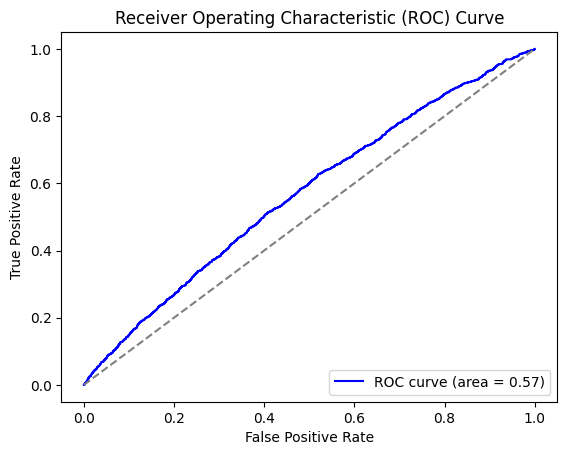

In [ ]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Hyperparameter Tuning

In [ ]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow import keras

# Step 1: Define the model with hyperparameters
def build_model(hp):
    model = keras.Sequential()
    # Tune the number of units in the first Dense layer
    model.add(keras.layers.Dense(units=hp.Int('units', min_value=16, max_value=512, step=32),
                                 activation=hp.Choice('activation', ['relu', 'tanh']),
                                 input_shape=(X_train.shape[1],)))
    # Tune the number of hidden layers and units
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(keras.layers.Dense(units=hp.Int(f'layer_{i}_units', min_value=16, max_value=512, step=32),
                                     activation=hp.Choice('activation', ['relu', 'tanh'])))
    # Output layer
    model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Step 2: Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of hyperparameter configurations to try
    executions_per_trial=3,  # Repeat each configuration 3 times for robustness
    directory='my_tuner',
    project_name='olympic_model_tuning'
)

# Step 3: Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Step 4: Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")
print(f"Best activation: {best_hps.get('activation')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

# Step 5: Train the best model
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

# Evaluate the model
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_acc:.4f}")

Trial 5 Complete [00h 05m 15s]
val_accuracy: 0.859381914138794

Best val_accuracy So Far: 0.859381914138794
Total elapsed time: 00h 25m 21s
Best number of units: 304
Best activation: relu
Best learning rate: 0.01
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4290/4290 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8390 - loss: 318.3744 - val_accuracy: 0.8594 - val_loss: 0.5610
Epoch 2/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8600 - loss: 0.5604 - val_accuracy: 0.8594 - val_loss: 0.5620
Epoch 3/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8565 - loss: 0.5697 - val_accuracy: 0.8594 - val_loss: 0.5607
Epoch 4/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8585 - loss: 0.5641 - val_accuracy: 0.8594 - val_loss: 0.5612
Epoch 5/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8594 - loss: 0.5617 - val_accuracy: 0.8594 - val_loss: 0.5612
Epoch 6/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8575 - loss: 0.5666 - val_accuracy: 0.8594 - val_loss: 0.5615
Epoch 7/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8580 - loss: 0.5653 - val_accuracy: 0.8594 - val_loss: 0.5607
Epoch 8/20
4290/4290 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8603 - loss: 0.5585 - val_accu

# F1 Score

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.7940
